# Example

In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from matplotlib import pyplot as plt
import matplotlib
% matplotlib inline
from subprocess import call, Popen, PIPE

from madminer import GoldMine, Smithy
from madminer.tools.plots import plot_2d_morphing_basis
from delphesminer import DelphesMiner

## 1. Define parameter space

In [13]:
miner = GoldMine()

miner.add_parameter(
    lha_block='ANOINPUTS',
    lha_id=3,
    parameter_name='fW',
    morphing_max_power=4,
    parameter_range=(-1.2e-05,1.2e-05)
)
miner.add_parameter(
    lha_block='ANOINPUTS',
    lha_id=7,
    parameter_name='fWW',
    morphing_max_power=4,
    parameter_range=(-1.2e-05,1.2e-05)
)

## 2. Define benchmark points (evaluation points for |M|^2)

### 2a. Set benchmarks by hand

In [14]:
miner.add_benchmark(
    {'fW':0., 'fWW':0.},
    'sm'
)

### 2b. Optimize benchmarks for morphing

In [15]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_bases=1,
    n_trials=1000,
    n_test_thetas=100
)

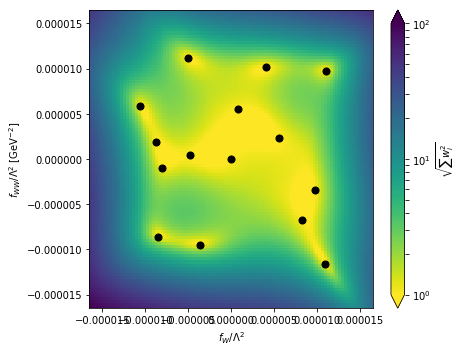

In [16]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$f_{W} / \Lambda^2$',
    ylabel=r'$f_{WW} / \Lambda^2$ [GeV${}^{-2}$]',
    xrange=(-1.64949627e-05, 1.64949627e-05),
    yrange=(-1.64949627e-05, 1.64949627e-05),
)

## 3. Save settings and run MadGraph

In [17]:
miner.save('data/madminer_example.h5')

In [ ]:
miner.run(
    mg_directory='/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2',
    proc_card_file='./cards/proc_card.dat',
    param_card_template_file='./cards/param_card_template.dat',
    reweight_card_template_file='./cards/reweight_card_template.dat',
    run_card_file='./cards/run_card.dat',
    sample_benchmark='sm',
    initial_command='source activate python2'
)

## 4. Run detector simulation and extract observables

To increase flexibility, this is not part of the madminer package. The delphesminer package includes the necessary steps based on Delphes

In [ ]:
dm = DelphesMiner()

In [ ]:
dm.add_hepmc_sample('./MG_process/Events/run_01/tag_1_pythia8_events.hepmc.gz')

In [ ]:
dm.run_delphes('/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes',
               './cards/delphes_card.dat')

In [ ]:
dm.add_observable('n_jets', 'len(j)')
dm.add_observable('pt_j1', 'j[0].pt')
dm.add_observable('pt_j2', 'j[1].pt')
dm.add_observable('m_jj', '(j[0] + j[1]).m')
dm.add_observable('delta_eta_jj', 'abs(j[0].eta() - j[1].eta())')
dm.add_observable('delta_phi_jj', 'abs(j[0].phi() - j[1].phi())')

In [ ]:
dm.analyse_delphes_samples()

In [ ]:
dm.save('data/madminer_example_with_data.h5', 'data/madminer_example.h5')

In [ ]:
import uproot

root_file = uproot.open(dm.delphes_sample_filenames[0])
tree = root_file['Delphes']
print(tree.keys())

## 5. Make training and test samples

In [ ]:
smithy = Smithy('data/madminer_example_with_data.h5')

In [ ]:
print(smithy.parameters)
print(miner.parameters == smithy.parameters)
fig = plot_2d_morphing_basis(smithy.morpher, xlabel=r'$f_{W}$', ylabel=r'$f_{WW}$')

In [ ]:
theta, x, gold = smithy.extract_sample(theta_sampling_types=['benchmark'],
                                       theta_sampling_values=[0],
                                       n_samples_per_theta=10,
                                       augmented_data_definitions=[('ratio', 'benchmark', 1, 'benchmark', 0)])